# **Cybersecurity Intrusion Detection Using Ensemble Methods**
- **Background:** In today's digital era, network security is of paramount importance. Cyberattacks are becoming increasingly sophisticated, threatening the integrity of data and IT infrastructure. This project aims to develop a machine learning-based intrusion detection system (IDS) that can quickly and accurately identify suspicious network activities.
- **Dataset:** The dataset comprises both network-based and user behavior-based features, including:
    - **Network-Based Features:**
        - **network_packet_size:** The size of data packets, which can indicate abnormal activity (e.g., packets that are unusually small or large).
        - **protocol_type:** The type of protocol (TCP, UDP, ICMP) used during the session, providing insight into the nature of the communication.
        - **encryption_used:** The encryption method (AES, DES, or None) employed, indicating the security level of the communication.
    - **User Behavior-Based Features:**
        - **login_attempts:** The number of login attempts. Extremely high values may indicate a brute-force attack.
        - **session_duration:** The duration of a user's session. Abnormally long sessions can signal unusual or unauthorized activity.
        - **failed_logins:** The number of failed login attempts, which may be indicative of credential stuffing attacks.
        - **unusual_time_access:** A binary flag indicating whether access occurred outside normal business hours.
        - **ip_reputation_score:** A score (ranging from 0 to 1) that reflects the trustworthiness of an IP address; higher scores suggest suspicious activity.
        - **browser_type:** The type of browser used, where an “Unknown” value may suggest the use of bots or automated scripts.
    - The target variable, attack_detected, is binary (1 indicates an attack detected, 0 indicates normal activity).
- **Methodological Approach:** This project adopts a supervised learning approach using several robust ensemble classification algorithms, including:
    - **AdaBoost:** Combines multiple weak learners (e.g., decision stumps) to improve the model's overall accuracy.
    - **XGBoost & LightGBM:** Two popular boosting algorithms known for their performance, scalability, and ability to handle complex feature interactions.
    - **Random Forest:** Uses multiple decision trees to improve model generalization and reduce overfitting.
- **Development Process:**
    - **Data Preprocessing and Exploration:**
        - Data cleaning, handling missing values, and encoding categorical variables.
        - Feature analysis to understand each feature's contribution to the target and to identify anomalous patterns.
    - **Modelling:**
        - Building classification models using the ensemble algorithms mentioned above.
        - Splitting the dataset into training and testing sets to validate performance.
        - Performing hyperparameter tuning (using techniques such as RandomizedSearchCV and BayesSearchCV) to optimize each model's configuration.
    - **Model Evaluation:**
        - Using evaluation metrics such as accuracy, precision, recall, and F1-score to assess model performance.
        - Analyzing the confusion matrix to understand classification errors.
        - Comparing the performance of each algorithm to determine the optimal model.

- **Benefits and Applications:**
    - **Attack Prevention:** By detecting intrusions in real-time, the system can provide early warnings and help prevent further damage to network infrastructure.
    - **Security System Enhancement:** The outcomes of this project can be used to improve intrusion detection systems (IDS) and support further research in the field of cybersecurity.

- **Conclusion:** This project demonstrates how ensemble methods in supervised learning—such as AdaBoost, XGBoost, LightGBM, and Random Forest—can be implemented to detect cyberattacks with high accuracy. Through comprehensive hyperparameter tuning and evaluation, the developed system is expected to become a vital component in future cybersecurity strategies.


# **Import Library**

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.api.types
import math
import lightgbm
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, TensorDataset
from lightgbm import LGBMClassifier, LGBMRegressor
from scipy.stats import zscore, randint, uniform, loguniform
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, davies_bouldin_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier, XGBRegressor
from lifelines.utils import concordance_index
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

# JCOPML Package
from jcopml.plot import plot_missing_value
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import random_search_params as rsp
from jcopml.feature_importance import mean_loss_decrease
from jcopml.feature_importance import mean_score_decrease
from jcopml.tuning import bayes_search_params as bsp
from jcopml.tuning import grid_search_params as gsp

# **Import Dataset**

In [2]:
train_df = pd.read_csv('data/cybersecurity_intrusion_data.csv')
train_df.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [3]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB
None


In [4]:
print("Total Missing Value : ")
print(train_df.isnull().sum())

Total Missing Value : 
session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64


# **Exploratory Data Analysis**

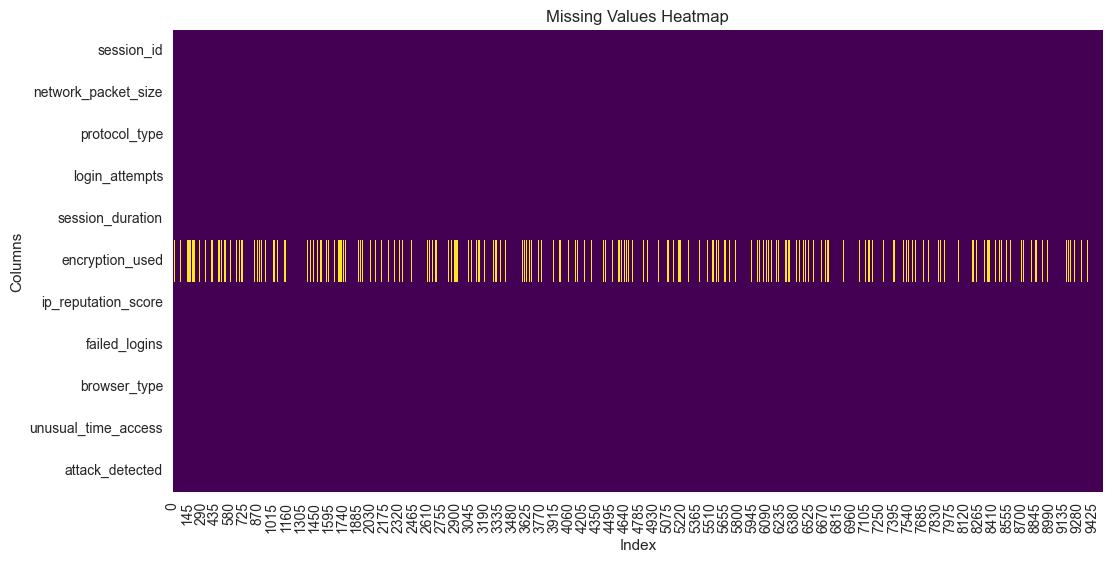

In [6]:
train_df_transposed = train_df.T

plt.figure(figsize=(12, 6))  
sns.heatmap(train_df_transposed.isnull(), cbar=False, cmap='viridis')  
plt.title("Missing Values Heatmap")
plt.xlabel("Index")
plt.ylabel("Columns")
plt.show()

Fill the missing value with mode

In [7]:
train_df = train_df.apply(lambda col: col.fillna(col.mode()[0]))

In [8]:
num_col = train_df.select_dtypes(include=[np.number])   
cat_col = train_df.select_dtypes(include=[object])

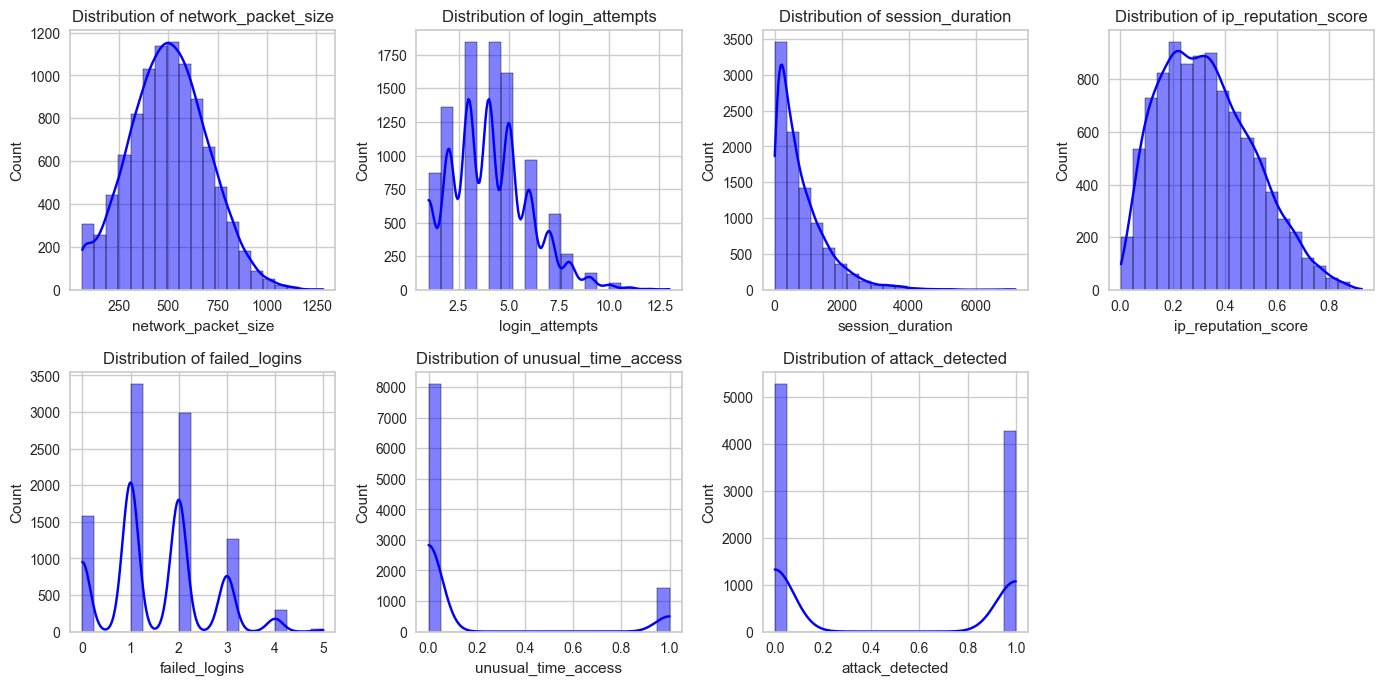

In [9]:
# EDA for Categoric Columns
plt.figure(figsize=(14, 10))
for i, column in enumerate(num_col.columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(train_df[column], bins=20, kde=True, color='blue')
    plt.title(f"Distribution of {column}")
plt.tight_layout()
plt.show()

Plotting: 100%|██████████| 4/4 [00:00<00:00, 11.04it/s]


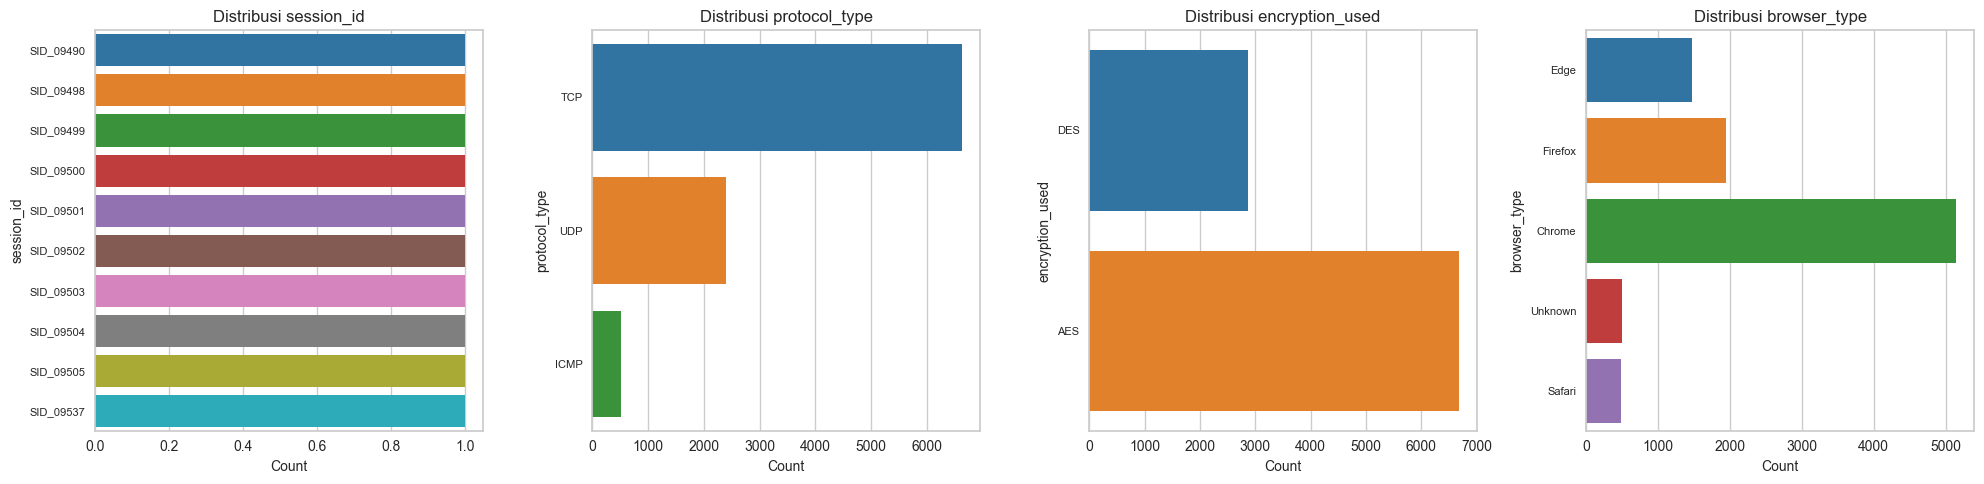

In [10]:
# EDA untuk Distribusi data kategorik
size_cat = len(cat_col.columns)
rows = math.ceil(size_cat / 4) 
fig, axes = plt.subplots(rows, 4, figsize=(20, 5 * rows))
axes = axes.flatten()  

for i, column in tqdm(enumerate(cat_col.columns), total=size_cat, desc="Plotting"):
    top_categories = train_df[column].value_counts().nlargest(10).index
    filtered_df = train_df[train_df[column].isin(top_categories)]
    sns.countplot(y=filtered_df[column], hue=filtered_df[column], ax=axes[i], palette='tab10', legend=False)
    axes[i].set_title(f'Distribusi {column}', fontsize=12)
    axes[i].set_xlabel('Count', fontsize=10)
    axes[i].set_ylabel(column, fontsize=10)
    
    plt.setp(axes[i].get_yticklabels(), fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [11]:
encoder = LabelEncoder()

for column in cat_col.columns:
    train_df[column] = encoder.fit_transform(train_df[column])

In [12]:
num_col_new = train_df.select_dtypes(include=[np.number])

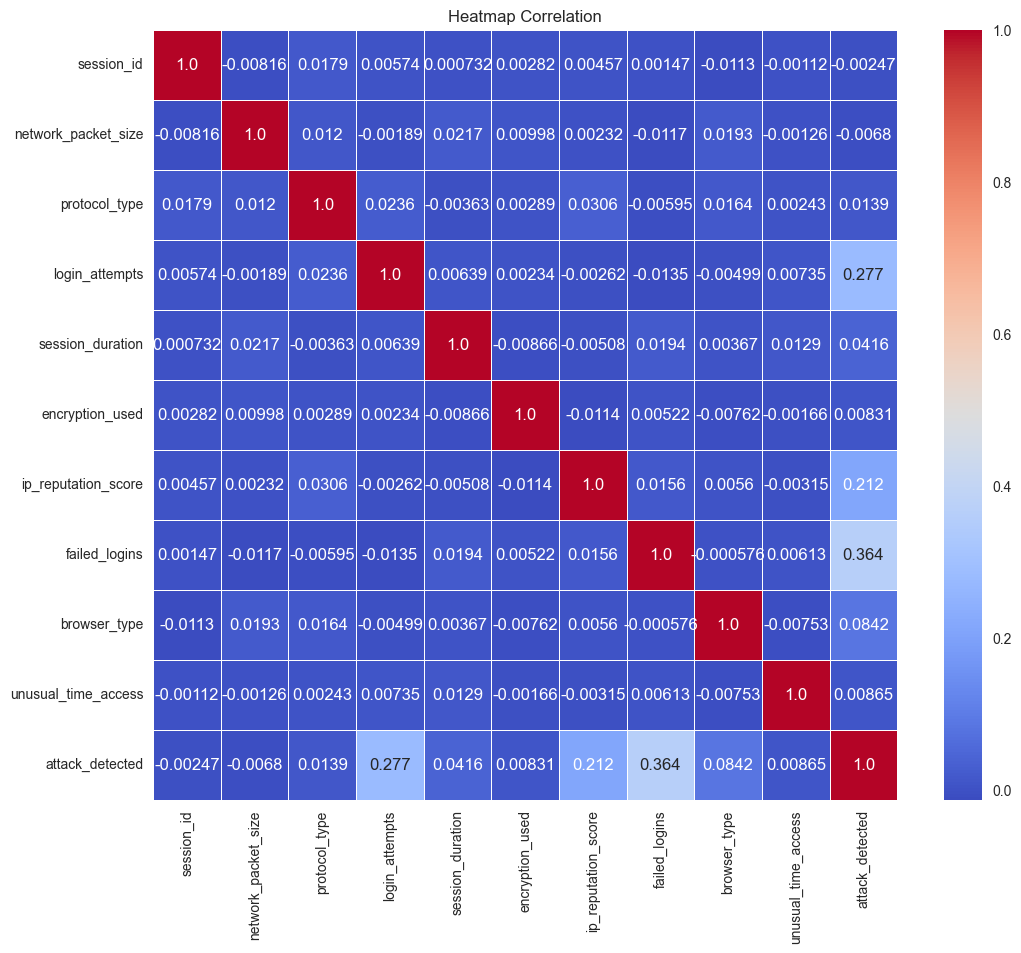

In [15]:
plt.figure(figsize=(12, 10))
correlation_matrix = num_col_new.corr()  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.3', linewidths=0.5)
plt.title('Heatmap Correlation')
plt.show()

# **Dataset Splitting**

In [19]:
X = train_df.drop(columns=['attack_detected'], axis=1)
y = train_df['attack_detected']
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((7629, 10), (1908, 10), (7629,), (1908,))

In [38]:
model_ada = AdaBoostClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgb_clf = LGBMClassifier(
    objective='binary',        
    boosting_type='gbdt',
    num_leaves=41,
    learning_rate=0.023,
    colsample_bytree=1.0,
    n_estimators=600,
    metric='accuracy',        
    random_state=42
)


In [39]:
model_ada.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
lgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],  
    eval_metric="auc",  
    callbacks=[lightgbm.log_evaluation(30)]  
)

c:\Users\windows\Documents\Python\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3411, number of negative: 4218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 7629, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447110 -> initscore=-0.212356
[LightGBM] [Info] Start training from score -0.212356
[30]	valid_0's auc: 0.86926
[60]	valid_0's auc: 0.87162
[90]	valid_0's auc: 0.875221
[120]	valid_0's auc: 0.876254
[150]	valid_0's auc: 0.878422
[180]	valid_0's auc: 0.879222
[210]	valid_0's auc: 0.878396
[240]	valid_0's auc: 0.877945
[270]	valid_0's auc: 0.877558
[300]	valid_0's auc: 0.87745
[330]	valid_0's auc: 0.878187
[360]	valid_0's auc: 0.877936
[390]	valid_0's auc: 0.877784
[420]	valid_0's auc: 0.87764
[450]	valid_0's auc: 0.877712
[4

LGBMClassifier(learning_rate=0.023, metric='accuracy', n_estimators=600,
               num_leaves=41, objective='binary', random_state=42)

In [40]:
# Score Training and Test model ada
print(f"Score Training adaaboost            : {model_ada.score(X_train, y_train)}")
print(f"Score Testing  adaaboost            : {model_ada.score(X_val, y_val)}")
print("\n")

# Score Training and Test model XGB
print(f"Score Training XGB                  : {xgb.score(X_train, y_train)}")
print(f"Score Testing  XGB                  : {xgb.score(X_val, y_val)}")
print("\n")

# Score Training and Test model Random Forest
print(f"Score Training RF                   : {rf.score(X_train, y_train)}")
print(f"Score Testing  RF                   : {rf.score(X_val, y_val)}")
print("\n")

# Score Training and Test model LGBM Classification
print(f"Score Training LGBM Classification  : {lgb_clf.score(X_train, y_train)}")
print(f"Score Testing  LGBM Classification  : {lgb_clf.score(X_val, y_val)}")

Score Training adaaboost            : 0.8858303840608206
Score Testing  adaaboost            : 0.8721174004192872


Score Training XGB                  : 0.9491414340018351
Score Testing  XGB                  : 0.879979035639413


Score Training RF                   : 1.0
Score Testing  RF                   : 0.8846960167714885


Score Training LGBM Classification  : 0.9539913488006292
Score Testing  LGBM Classification  : 0.8841719077568134


# **Evaluation Without Hyperparameter Tunning**

In [42]:
print("Adaboost Evaluation : ")
y_val_pred_ada = model_ada.predict(X_val)
report_model_ada = classification_report(y_val, y_val_pred_ada)
print("Classification Report:")
print(report_model_ada)

cm_model_ada = confusion_matrix(y_val, y_val_pred_ada)
print("\nConfusion Matrix model_ada :")
print(cm_model_ada)
print("model_ada Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_ada, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_ada, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_ada, average='macro', zero_division=0):.4f}")

print("\n")
print("XGB Classification Evaluation : ")
y_val_pred_xgb = xgb.predict(X_val)
report_xgb = classification_report(y_val, y_val_pred_xgb)
print("Classification Report:")
print(report_xgb)

cm_xgb = confusion_matrix(y_val, y_val_pred_xgb)
print("\nConfusion Matrix xgb :")
print(cm_xgb)
print("xgb Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_xgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_xgb, average='macro', zero_division=0):.4f}")


print("\n")
print("Random Forest Evaluation : ")
y_val_pred_rf = rf.predict(X_val)
report_rf = classification_report(y_val, y_val_pred_rf)
print("Classification Report:")
print(report_rf)

cm_rf = confusion_matrix(y_val, y_val_pred_rf)
print("\nConfusion Matrix rf :")
print(cm_rf)
print("rf Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_rf, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_rf, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_rf, average='macro', zero_division=0):.4f}")

print("\n")
print("LGBM Classifier Evaluation : ")
y_val_pred_lgb = lgb_clf.predict(X_val)
report_lgb = classification_report(y_val, y_val_pred_lgb)
print("Classification Report:")
print(report_lgb)

cm_lgb = confusion_matrix(y_val, y_val_pred_lgb)
print("\nConfusion Matrix lgb :")
print(cm_lgb)
print("LGBM Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_pred_lgb, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_pred_lgb, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_pred_lgb, average='macro', zero_division=0):.4f}")


Adaboost Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1055
           1       0.96      0.74      0.84       853

    accuracy                           0.87      1908
   macro avg       0.89      0.86      0.87      1908
weighted avg       0.89      0.87      0.87      1908


Confusion Matrix model_ada :
[[1030   25]
 [ 219  634]]
model_ada Evaluation :
Precision (macro): 0.8934
Recall (macro): 0.8598
F1-Score (macro): 0.8664


XGB Classification Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      1055
           1       0.97      0.75      0.85       853

    accuracy                           0.88      1908
   macro avg       0.90      0.87      0.87      1908
weighted avg       0.89      0.88      0.88      1908


Confusion Matrix xgb :
[[1037   18]
 [ 211  642]]
xgb Evaluation :
Precision (macro): 0

# **Hyperparameter Tunning**

## **Tunning : Randomized Search CV**

In [47]:
base_estimator = DecisionTreeClassifier(max_depth=1)
model_ada = AdaBoostClassifier(estimator=base_estimator, algorithm="SAMME", random_state=42)

param_ada = {
    'n_estimators': np.arange(50, 201, 10),  
    'learning_rate': np.linspace(0.1, 2.0, 10), 
    'estimator__max_depth': [1, 2, 3, 4, 5]  
}

rsp_ada = RandomizedSearchCV(
    estimator=model_ada, 
    param_distributions=param_ada, 
    n_iter=30, 
    cv=5, 
    scoring='accuracy', 
    random_state=42
)

rsp_ada.fit(X_train, y_train)
print(f"Model best params : {rsp_ada.best_params_}")
print(f"Hasil train       : {rsp_ada.score(X_train, y_train)}")
print(f"Hasil test        : {rsp_ada.score(X_val, y_val)}")

Model best params : {'n_estimators': np.int64(60), 'learning_rate': np.float64(1.1555555555555557), 'estimator__max_depth': 5}
Hasil train       : 0.8974963953335955
Hasil test        : 0.8857442348008385


In [52]:
pipeline_xgb = Pipeline([
    ('algo', XGBClassifier(random_state=42))
])
rsp_param_xgb = {
    'algo__max_depth': randint(1, 11), 
    'algo__learning_rate': loguniform(1e-2, 1e-1),
    'algo__n_estimators': randint(100, 201),
    'algo__subsample': uniform(0.3, 0.5),  
    'algo__gamma': randint(1, 11),
    'algo__colsample_bytree': uniform(0.1, 0.9),
    'algo__reg_alpha': loguniform(1e-3, 10),
    'algo__reg_lambda': loguniform(1e-3, 10)
}

xgb_rsp = RandomizedSearchCV(estimator=pipeline_xgb, param_distributions=rsp_param_xgb, n_iter=50, cv=5, n_jobs=-1, verbose=1)
xgb_rsp.fit(X_train, y_train)
print(f"Model best params : {xgb_rsp.best_params_}")
print(f"Hasil train       : {xgb_rsp.score(X_train, y_train)}")
print(f"Hasil test        : {xgb_rsp.score(X_val, y_val)}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Model best params : {'algo__colsample_bytree': np.float64(0.9698606397085304), 'algo__gamma': 1, 'algo__learning_rate': np.float64(0.036263399434727686), 'algo__max_depth': 7, 'algo__n_estimators': 134, 'algo__reg_alpha': np.float64(0.026876263479408188), 'algo__reg_lambda': np.float64(0.11362157367865225), 'algo__subsample': np.float64(0.7557683934026524)}
Hasil train       : 0.8974963953335955
Hasil test        : 0.8857442348008385


In [53]:
rsp_param_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 50, 80],
    'max_features': [0.1, 0.5, 1],
    'min_samples_leaf': [1, 10, 20] 
}

rsp_rf = RandomizedSearchCV(estimator=rf, param_distributions=rsp_param_rf, n_iter=50, cv=5, n_jobs=-1, verbose=1)
rsp_rf.fit(X_train, y_train)
print(f"Model best params : {rsp_rf.best_params_}")
print(f"Hasil train       : {rsp_rf.score(X_train, y_train)}")
print(f"Hasil test        : {rsp_rf.score(X_val, y_val)}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Model best params : {'n_estimators': 200, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 50}
Hasil train       : 0.8974963953335955
Hasil test        : 0.8862683438155137


### **Randomized Search CV Model Evaluation**

In [55]:
print("Adaboost Evaluation : ")
best_ada_rsp = rsp_ada.best_estimator_
y_val_rsp_ada = best_ada_rsp.predict(X_val)
report_best_ada = classification_report(y_val, y_val_rsp_ada)
print("Classification Report:")
print(report_best_ada)

cm_best_ada = confusion_matrix(y_val, y_val_rsp_ada)
print("\nConfusion Matrix Adaboost Evaluation :")
print(cm_best_ada)
print("Adaboost Model Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_rsp_ada, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_rsp_ada, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_rsp_ada, average='macro', zero_division=0):.4f}")

print("\n")
print("XGB Classification Evaluation : ")
best_xgb_rsp =  xgb_rsp.best_estimator_
y_val_xgb_rsp = best_xgb_rsp.predict(X_val)
report_xgb_rsp = classification_report(y_val, y_val_xgb_rsp)
print("Classification Report:")
print(report_xgb_rsp)

cm_xgb_rsp = confusion_matrix(y_val, y_val_xgb_rsp)
print("\nConfusion Matrix xgb :")
print(cm_xgb_rsp)
print("XGB Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_xgb_rsp, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_xgb_rsp, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_xgb_rsp, average='macro', zero_division=0):.4f}")


print("\n")
print("Random Forest Evaluation : ")
best_rf_rsp =  rsp_rf.best_estimator_
y_val_rf_rsp = best_rf_rsp.predict(X_val)
report_rf_rsp = classification_report(y_val, y_val_rf_rsp)
print("Classification Report:")
print(report_rf_rsp)

cm_rf_rsp = confusion_matrix(y_val, y_val_rf_rsp)
print("\nConfusion Matrix rf :")
print(cm_rf_rsp)
print("Random Forest Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_rf_rsp, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_rf_rsp, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_rf_rsp, average='macro', zero_division=0):.4f}")

Adaboost Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908


Confusion Matrix Adaboost Evaluation :
[[1054    1]
 [ 217  636]]
Adaboost Model Evaluation :
Precision (macro): 0.9138
Recall (macro): 0.8723
F1-Score (macro): 0.8800


XGB Classification Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908


Confusion Matrix xgb :
[[1054    1]
 [ 217  636]]
XGB Evaluation :
Preci

## **Tunning : Bayes Search CV Evaluation**

In [63]:
base_estimator = DecisionTreeClassifier(max_depth=1)
model_ada_bsp = AdaBoostClassifier(estimator=base_estimator, algorithm="SAMME", random_state=42)

param_ada_bayes = {
    'n_estimators': Integer(50, 200),              
    'learning_rate': Real(0.1, 2.0, prior='uniform'), 
    'estimator__max_depth': Integer(1, 5)            
}

ada_bayes = BayesSearchCV(
    estimator=model_ada_bsp,
    search_spaces=param_ada_bayes,
    n_iter=30,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

ada_bayes.fit(X_train, y_train)
print(f"Model best params : {ada_bayes.best_params_}")
print(f"Hasil train       : {ada_bayes.score(X_train, y_train)}")
print(f"Hasil test        : {ada_bayes.score(X_val, y_val)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [60]:
bsp_param_xgb = {
    'algo__max_depth': Integer(low=1, high=10, prior='uniform', transform='identity'),
    'algo__learning_rate': Real(low=0.01, high=1, prior='log-uniform', transform='identity'),
    'algo__n_estimators': Integer(low=100, high=200, prior='uniform', transform='identity'),
    'algo__subsample': Real(low=0.3, high=0.8, prior='uniform', transform='identity'),
    'algo__gamma': Integer(low=1, high=10, prior='uniform', transform='identity'),
    'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform', transform='identity'),
    'algo__reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='identity'),
    'algo__reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='identity')
}

pipeline_xgb = Pipeline([
    ('algo', xgb)
])

xgb_bsp = BayesSearchCV(
    estimator=pipeline_xgb, 
    search_spaces=bsp_param_xgb, 
    n_iter=50, 
    cv=5, 
    n_jobs=-1, 
    verbose=1
)

xgb_bsp.fit(X_train, y_train)
print(f"Model best params : {xgb_bsp.best_params_}")
print(f"Hasil train       : {xgb_bsp.score(X_train, y_train)}")
print(f"Hasil test        : {xgb_bsp.score(X_val, y_val)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [62]:
bsp_param_rf = {
    'n_estimators': Integer(low=100, high=200, prior='uniform', transform='identity'),
    'max_depth': Integer(low=20, high=80, prior='uniform', transform='identity'),
    'max_features': Real(low=0.1, high=1, prior='uniform', transform='identity'),
    'min_samples_leaf': Integer(low=1, high=20, prior='uniform', transform='identity')
}

rf_bsp = BayesSearchCV(
    estimator=rf, 
    search_spaces=bsp_param_rf, 
    n_iter=50, 
    cv=5, 
    n_jobs=-1, 
    verbose=1)
rf_bsp.fit(X_train, y_train)
print(f"Model best params : {rf_bsp.best_params_}")
print(f"Hasil train       : {rf_bsp.score(X_train, y_train)}")
print(f"Hasil test        : {rf_bsp.score(X_val, y_val)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

### **Bayesian Search CV Model Evaluation**

In [64]:
print("Adaboost Evaluation : ")
best_ada_bsp = ada_bayes.best_estimator_
y_val_bsp_ada = best_ada_bsp.predict(X_val)
report_bsp_ada = classification_report(y_val, y_val_bsp_ada)
print("Classification Report:")
print(report_bsp_ada)

cm_ada_bsp = confusion_matrix(y_val, y_val_bsp_ada)
print("\nConfusion Matrix Adaboost Evaluation :")
print(cm_ada_bsp)
print("Adaboost Model Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_bsp_ada, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_bsp_ada, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_bsp_ada, average='macro', zero_division=0):.4f}")

print("\n")
print("XGB Classification Evaluation : ")
best_xgb_bsp =  xgb_bsp.best_estimator_
y_val_xgb_bsp = best_xgb_bsp.predict(X_val)
report_xgb_bsp = classification_report(y_val, y_val_xgb_bsp)
print("Classification Report:")
print(report_xgb_bsp)

cm_xgb_bsp = confusion_matrix(y_val, y_val_xgb_bsp)
print("\nConfusion Matrix xgb :")
print(cm_xgb_bsp)
print("XGB Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_xgb_bsp, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_xgb_bsp, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_xgb_bsp, average='macro', zero_division=0):.4f}")


print("\n")
print("Random Forest Evaluation : ")
best_rf_bsp =  rf_bsp.best_estimator_
y_val_rf_bsp = best_rf_bsp.predict(X_val)
report_rf_bsp = classification_report(y_val, y_val_rf_bsp)
print("Classification Report:")
print(report_rf_bsp)

cm_rf_bsp = confusion_matrix(y_val, y_val_rf_bsp)
print("\nConfusion Matrix rf :")
print(cm_rf_bsp)
print("Random Forest Evaluation :")
print(f"Precision (macro): {precision_score(y_val, y_val_rf_bsp, average='macro', zero_division=0):.4f}")
print(f"Recall (macro): {recall_score(y_val, y_val_rf_bsp, average='macro'):.4f}")
print(f"F1-Score (macro): {f1_score(y_val, y_val_rf_bsp, average='macro', zero_division=0):.4f}")

Adaboost Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908


Confusion Matrix Adaboost Evaluation :
[[1054    1]
 [ 217  636]]
Adaboost Model Evaluation :
Precision (macro): 0.9138
Recall (macro): 0.8723
F1-Score (macro): 0.8800


XGB Classification Evaluation : 
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1055
           1       1.00      0.75      0.85       853

    accuracy                           0.89      1908
   macro avg       0.91      0.87      0.88      1908
weighted avg       0.90      0.89      0.88      1908


Confusion Matrix xgb :
[[1054    1]
 [ 217  636]]
XGB Evaluation :
Preci